In [1]:
import os
import json

from honeybee.room import Room
from honeybee.model import Model
from honeybee_vtk.model import Model as md
from honeybee.boundarycondition import boundary_conditions
from honeybee_energy.hvac.idealair import IdealAirSystem
from honeybee_energy.simulation.output import SimulationOutput
from honeybee_energy.simulation.runperiod import RunPeriod
from honeybee_energy.simulation.parameter import SimulationParameter
from honeybee_energy.simulation.control import SimulationControl
from honeybee_energy.simulation.shadowcalculation import ShadowCalculation
from honeybee_energy.run import to_openstudio_osw, run_osw, run_idf, output_energyplus_files
from ladybugtools_toolkit.prototypes.BoxModel.box_model import EnergySettings
from honeybee_energy.result.loadbalance import LoadBalance

from ladybug.futil import preparedir, nukedir
from ladybug.epw import EPW

from honeybee_energy.construction import window
import json
from honeybee_energy.material.glazing import EnergyWindowMaterialGlazing
from honeybee.typing import clean_and_id_ep_string, clean_ep_string
from ladybug_charts.to_figure import bar_chart, diurnal_average_chart_from_hourly, heat_map, hourly_line_chart, bar_chart_with_table
from ladybug.datacollection import HourlyDiscontinuousCollection
from ladybug.color import Colorset

ModuleNotFoundError: No module named 'ladybugtools_toolkit.prototypes'

In [2]:
from honeybee.model import Model
from honeybee_ies.reader import model_from_ies
from honeybee_vtk.model import Model as VTKModel

model = model_from_ies(r"C:\Users\cbrooker\Desktop\IES\Vitrum\PV Test\230214 Vitrum Part L 05 750m2 PV.gem")
vtk_model = VTKModel(model).to_html(name = 'Test', show = True)

ModelDataSet: Door has no data to be exported to folder.
ModelDataSet: Grid has no data to be exported to folder.


In [ ]:
folder = r"C:\Users\cbrooker\Desktop\Box_Model\Temp"
hb_json_path = r"C:\Users\cbrooker\Desktop\IES\BM_HBJSON.hbjson"
epw_file = r"C:\Program Files\IES\Shared Content\Weather\GBR_ENG_London.Wea.Ctr-St.James.Park.037700_TMYx.2004-2018.epw"

hb_model = Model.from_hbjson(hb_json_path)
hb_model = hb_model.duplicate()
clean_name = re.sub(r'[^.A-Za-z0-9_-]', '_', hb_model.display_name)
directory = os.path.join(folder, clean_name, 'openstudio')
epw_obj = EPW(epw_file)
silent = False

In [ ]:
# Prepare folders
nukedir(directory, True)
preparedir(directory)
sch_directory = os.path.join(directory, 'schedules')
preparedir(sch_directory)

True

In [ ]:
# Produce energy settings JSON
# get energy settings and suplicate so original is unchanged
energy_parameters = EnergySettings().simulation_parameters()
energy_parameters = energy_parameters.duplicate()

# add autocalculated design days
des_days = [epw_obj.approximate_design_day('WinterDesignDay'),
            epw_obj.approximate_design_day('SummerDesignDay')]
energy_parameters.sizing_parameter.design_days = des_days

# create json of energy parameters for iput to simulation
energy_param_dict = energy_parameters.to_dict()
energy_param_json = os.path.join(directory, 'simulation_parameter.json')
with open(energy_param_json, 'w') as fp:
    json.dump(energy_param_dict, fp)

In [ ]:
# Produce model parameters JSON
model_dict = hb_model.to_dict(triangulate_sub_faces=True)
hb_model.properties.energy.add_autocal_properties_to_dict(model_dict)
model_json = os.path.join(directory, '{}.hbjson'.format(clean_name))
with open(model_json, 'w') as fp:
    json.dump(model_dict, fp)

In [ ]:
from honeybee_energy.run import to_openstudio_osw, run_osw, run_idf
import re

osw_path = to_openstudio_osw(model_path = hb_json_path, osw_directory = directory, sim_par_json_path = energy_param_json)
osm, idf = run_osw(osw_json= osw_path, silent=silent)
sql, zsz, rdd, html, err = run_idf(idf_file_path = idf, epw_file_path = epw_file, silent=silent)

In [ ]:
sql_obj = SQLiteResult(sql)
sql_obj.available_outputs

('Surface Window Heat Gain Energy',
 'Surface Window Heat Loss Energy',
 'Zone Infiltration Sensible Heat Gain Energy',
 'Zone Infiltration Sensible Heat Loss Energy',
 'Zone Electric Equipment Convective Heating Energy',
 'Zone Air Relative Humidity',
 'Zone Ideal Loads Supply Air Sensible Cooling Energy',
 'Zone People Sensible Heating Energy',
 'Zone Mean Air Temperature',
 'Zone Ideal Loads Zone Sensible Cooling Energy',
 'Zone Windows Total Transmitted Solar Radiation Energy',
 'Zone Ideal Loads Zone Sensible Heating Energy',
 'Zone Ideal Loads Supply Air Sensible Heating Energy',
 'Zone Mean Radiant Temperature',
 'Zone Electric Equipment Radiant Heating Energy',
 'Zone Operative Temperature',
 'Surface Inside Face Conduction Heat Transfer Energy',
 'Zone Lights Total Heating Energy')

In [ ]:
load_balance = LoadBalance.from_sql_file(model = hb_model, sql_path= sql)

In [ ]:
hourly_collections = load_balance.load_balance_terms(floor_normalized=True, include_storage=True)
hourly_collections

[Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 Energy Intensity (kWh/m2)
 ...8760 values...,
 Hourly Continuous Data Collection
 1/1 to 12/31 between 0 and 23 @1
 En

In [ ]:
monthly_collections = []
for data in hourly_collections:
    monthly_collections.append(data.total_monthly())

colors = Colorset.energy_balance_storage()
bar_chart(monthly_collections, stack= True, colors= colors)

In [ ]:
hb_model.properties.energy.to_dict()

{'energy': {'type': 'ModelEnergyProperties',
  'global_construction_set': {'type': 'GlobalConstructionSet',
   'wall_set': {'type': 'WallConstructionSetAbridged',
    'exterior_construction': 'Generic Exterior Wall',
    'interior_construction': 'Generic Interior Wall',
    'ground_construction': 'Generic Underground Wall'},
   'floor_set': {'type': 'FloorConstructionSetAbridged',
    'exterior_construction': 'Generic Exposed Floor',
    'interior_construction': 'Generic Interior Floor',
    'ground_construction': 'Generic Ground Slab'},
   'roof_ceiling_set': {'type': 'RoofCeilingConstructionSetAbridged',
    'exterior_construction': 'Generic Roof',
    'interior_construction': 'Generic Interior Ceiling',
    'ground_construction': 'Generic Underground Roof'},
   'aperture_set': {'type': 'ApertureConstructionSetAbridged',
    'window_construction': 'Generic Double Pane',
    'interior_construction': 'Generic Single Pane',
    'skylight_construction': 'Generic Double Pane',
    'operab

In [ ]:
# prepare_idf_for_simulation
# run_idf()

In [ ]:
construction_json = r"C:\Users\cbrooker\Desktop\IES\BoxModelTesting\BoxModelTesting_ConstructionsData.json"

# importing the module
import json
 
# Opening JSON file
with open(r"C:\Users\cbrooker\Desktop\IES\BoxModelTesting\BoxModelTesting_ConstructionsData.json") as json_file:
    data = json.load(json_file)

list_of_constructions = data.get('constructions')

new_dict = {item['construction_name']:item for item in list_of_constructions}

layers = new_dict.get('2013 External Window').get('layers')

construction_materials = []

for layer in layers:
    print(layer)
    material_data = layer.get('material_properties')
    print(material_data)
    if "pane" in material_data.get('description').lower():
        name = clean_and_id_ep_string('GlassMaterial')
        material_data = layer.get('material_properties')
        thickness= material_data.get('thickness')
        solar_transmittance=material_data.get('transmittance')
        solar_reflectance=material_data.get('outside_reflectance')
        visible_transmittance=material_data.get('visible_transmittance')
        emissivity=material_data.get('outside_emissivity')
        emissivity_back=material_data.get('inside_emissivity')
        conductivity=material_data.get('conductivity')
        material = EnergyWindowMaterialGlazing(identifier=name,
                                    thickness=thickness,
                                    solar_transmittance=solar_transmittance,
                                    solar_reflectance=solar_reflectance,
                                    visible_transmittance=visible_transmittance,
                                    emissivity=emissivity,
                                    emissivity_back=emissivity_back,
                                    conductivity=conductivity)
    elif "cavity" in material_data.get('description').lower():
        material = 0
    construction_materials.append(material)

construction_materials


{'layer_id': 'LAYR0000', 'layer_properties': {'convection_coefficient': 0.0, 'resistance': 0.0, 'thickness': 0.0}, 'material_id': 'STD_EXW', 'material_properties': {'angular_dependence': 0, 'category': 99, 'conductivity': 1.059999942779541, 'description': 'Outer Pane', 'id': 'STD_EXW', 'inside_emissivity': 0.041999999433755875, 'inside_reflectance': 0.414000004529953, 'inside_visible_reflectance': 0.07000000029802322, 'outside_emissivity': 0.8370000123977661, 'outside_reflectance': 0.289000004529953, 'outside_visible_reflectance': 0.07000000029802322, 'pane_coating': 'Uncoated', 'refractive_index': 1.5260000228881836, 'specific_heat_capacity': 0.0, 'surface_type': 2, 'thickness': 0.006000000052154064, 'transmittance': 0.4090000092983246, 'visible_transmittance': 0.7799999713897705}}
{'angular_dependence': 0, 'category': 99, 'conductivity': 1.059999942779541, 'description': 'Outer Pane', 'id': 'STD_EXW', 'inside_emissivity': 0.041999999433755875, 'inside_reflectance': 0.414000004529953,

[WindowMaterial:Glazing,
  GlassMaterial_9c461079,   !- name
  SpectralAverage,          !- optical data type
  ,                         !- spectral data set name
  0.006000000052154064,     !- thickness {m}
  0.4090000092983246,       !- solar transmittance
  0.289000004529953,        !- solar reflectance front
  0.289000004529953,        !- solar reflectance back
  0.7799999713897705,       !- visible transmittance
  0.075,                    !- visible reflectance front
  0.075,                    !- visible reflectance back
  0.0,                      !- infrared_transmittance
  0.8370000123977661,       !- emissivity front
  0.041999999433755875,     !- emissivity back
  1.059999942779541,        !- conductivity {W/m-K}
  1.0,                      !- dirt correction factor
  No;                       !- solar diffusing,
 0,
 WindowMaterial:Glazing,
  GlassMaterial_fc3dc21d,   !- name
  SpectralAverage,          !- optical data type
  ,                         !- spectral data set

In [ ]:
construction_types = ['ext_glazing']

In [ ]:
#Inputs required across multiple parts

#Weather data
epw_file = r"C:\Program Files\IES\Shared Content\Weather\SAU_Riyadh.404380_IWEC.epw"
root_folder = r"C:\Users\cbrooker\Desktop\Box_Model"
model_name = "Test" # need to check and amend usage of model_name

In [ ]:
#Daylight performance info


In [ ]:
from honeybee_energy.programtype import ProgramType

#Room energy inputs - Gains, set points, etc.
#Example template produced in GH and dumped to JSON - TODO add functionality to switch between templates or adjust the template
program_template = r"C:\Users\cbrooker\Desktop\Box_Model\NABERS Program - to be reviewed.json"

with open(program_template) as fp:
    program_data = json.load(fp)

box_model_program = ProgramType.from_dict(program_data)

box_model_program.to_dict()


{'type': 'ProgramType',
 'identifier': 'NABERS Office',
 'people': {'type': 'People',
  'identifier': 'NABERS office occupancy',
  'people_per_area': 0.1,
  'radiant_fraction': 0.3,
  'latent_fraction': {'type': 'Autocalculate'},
  'occupancy_schedule': {'type': 'ScheduleFixedInterval',
   'identifier': 'NABERS office occupancy profile',
   'values': (0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.05,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.1,
    0.2,
    0.7,
    0.7,
    0.7,
    0.7,
    0.7,
    0.7,
    0.7,
    0.7,
    0.35,
    0.1,
    0.05,
    0.05,
    0.0,

In [ ]:
#HVAC inputs
#HVAC set up, ideal air
ideal_air_system = {
"type": "IdealAirSystem",
"identifier": "Box_Model Ideal Air System",  # identifier for the HVAC
"display_name": "Box_Model IdealAir",  # name for the HVAC
"economizer_type": 'NoEconomizer',  # Economizer type
"demand_controlled_ventilation": False,  # Demand controlled ventilation
"sensible_heat_recovery": 0,  # Sensible heat recovery effectiveness
"latent_heat_recovery": 0,  # Latent heat recovery effectiveness
"heating_air_temperature": 50,  # Heating supply air temperature
"cooling_air_temperature": 13,  # Cooling supply air temperature
"heating_limit": {'type': 'NoLimit'},  # Max size of the heating system
"cooling_limit": {'type': 'NoLimit'},  # Max size of the cooling system
#"heating_availability": {},  # Schedule for availability of heat or None
#"cooling_availability": {}  # Schedule for availability of cooling or None
}
box_model_hvac = IdealAirSystem.from_dict(ideal_air_system)

In [ ]:
#CB Note - review essential outputs from rdd and limit those to limit file size

#Simulation setting inputs

#Terrain type
terrain_type = 'Suburbs' # this has been set to match the default in IES

#Timestep
timestep = 6 #10 minute

#Simulation Output
sim_output = SimulationOutput(reporting_frequency="Hourly")
sim_output.add_zone_energy_use("Sensible")
sim_output.add_gains_and_losses("Sensible")
sim_output.add_comfort_metrics()
sim_output.add_surface_energy_flow()

#Run period
run_period = RunPeriod() #uses default run period settings, start day Sunday, year = 2017, no DST, etc.

#Simulation control - turn off sizing sims to speed up sim time
sim_control = SimulationControl()
""""
sim_control = SimulationControl(do_zone_sizing=True,
                                do_system_sizing=False,
                                do_plant_sizing=False,
                                run_for_run_periods=True) #

"""
#Shadow calculation, similar to IESVE Suncast
solar_dist = "FullExteriorWithReflections"
calc_method = "PolygonClipping"
update_method = "Periodic"
update_frequency = 30 # Lookup in Big Ladder what this means, is it timestep or days?
shadow_calc = ShadowCalculation(solar_distribution=solar_dist,
                                calculation_method=calc_method,
                                calculation_update_method=update_method,
                                calculation_frequency=update_frequency)

#Combine into simulation parameters
box_model_sim_par = SimulationParameter(output = sim_output,
                              run_period = run_period,
                              timestep = timestep,
                              simulation_control= sim_control,
                              shadow_calculation= shadow_calc,terrain_type= terrain_type)


In [ ]:
#Box model geometry setup
#Input variables - ranges to be defined also consider step widths (e.g. 2.5, 2.0, rather than 2.456)
count_bays = 3 # set min to 3 bays and max to 20?
bay_width = 3 # min 1.5, max 10? 
zone_height = 3.2 # min 2.5, max 10?
zone_depth = 4.5 # min 4, max 20?
glazing_ratio = 0.2 # min 0.05, max 0.95 (HB limit)
target_window_height = 2 # can we add some checks on these targets to say if they'll be achieved or not?
target_sill_height = 0.8

#calculated vars
room_width = count_bays*bay_width

#generate room
my_room = Room.from_box(model_name, width= room_width, depth=zone_depth)

#set all adjacnecies as adiabatic
for face in my_room.faces:
    face.boundary_condition = boundary_conditions.adiabatic

#add glazing
my_room.faces[1].boundary_condition = boundary_conditions.outdoors
my_room.faces[1].apertures_by_ratio_rectangle(ratio = glazing_ratio, aperture_height = target_window_height, sill_height = target_sill_height, horizontal_separation = bay_width)

#create model and add room to it
box_model = Model.from_objects(
    identifier="{0:}_Model".format(my_room.identifier), objects=[my_room]
)

#export model to html
test_web = md.from_hbjson(box_model.to_hbjson(name=model_name))
test_web.to_html(folder=".", name=model_name, show=True)
test_web.to_vtkjs(folder=".", name=model_name)


ModelDataSet: Door has no data to be exported to folder.
ModelDataSet: Shade has no data to be exported to folder.
ModelDataSet: AirBoundary has no data to be exported to folder.
ModelDataSet: Grid has no data to be exported to folder.
ModelDataSet: Door has no data to be exported to folder.
ModelDataSet: Shade has no data to be exported to folder.
ModelDataSet: AirBoundary has no data to be exported to folder.
ModelDataSet: Grid has no data to be exported to folder.


'c:\\Users\\cbrooker\\GitHub\\LadybugTools_Toolkit\\LadybugTools_Engine\\Python\\src\\ladybugtools_toolkit\\prototypes\\BoxModel\\Test.vtkjs'

In [ ]:
#Things to report - links to cell above on geometry creation

#Actual window size compared to target
#Z-value here to be compared against target_window_height
print((my_room.faces[1].apertures[0].max -my_room.faces[1].apertures[0].min))
#Z-value here to be compared against target_sill_height
print(my_room.faces[1].apertures[0].min)

Vector3D (0.96, 0.00, 2.00)
Point3D (7.02, 4.50, 0.80)


In [ ]:
# Constructions - worth including Radiance reflectances?

In [ ]:
#Apply everything to the room
my_room.properties.energy.program_type = box_model_program
my_room.properties.energy.hvac = box_model_hvac

In [ ]:
#Run energy simulation
directory = os.path.join(root_folder, "openstudio")
epw_obj = EPW(epw_file)

#Set up folders for running simulations
nukedir(directory, True)
preparedir(directory)
sch_directory = os.path.join(directory, 'schedules')
preparedir(sch_directory)

# write the model parameter JSONs
model_dict = box_model.to_dict(triangulate_sub_faces=True)
box_model.properties.energy.add_autocal_properties_to_dict(model_dict)
model_json = os.path.join(directory, '{}.hbjson'.format(box_model.display_name))
with open(model_json, 'w') as fp:
    json.dump(model_dict, fp)

# write the simulation parameter JSONs
sim_par_dict = box_model_sim_par.to_dict()
sim_par_json = os.path.join(directory, 'simulation_parameter.json')
with open(sim_par_json, 'w') as fp:
    json.dump(sim_par_dict, fp)

# collect the two jsons for output and write out the osw file - set up with no measures and no schedule directory 
jsons = [model_json, sim_par_json]
# note - there is an optional input for viz variables, to be investigated
osw = to_openstudio_osw(
    directory, model_json, sim_par_json,
    epw_file= epw_file, schedule_directory= sch_directory)

# Silent controls whether batch windows popup 
silent = False

# Run simulation
osm, idf = run_osw(osw, silent=silent)
sql, zsz, rdd, html, err = run_idf(idf, epw_file, silent=silent)


In [ ]:
# Results processing
# Look into E+ json file output, could be used for MongoDB / BHoM interaction

from ladybug.sql import SQLiteResult

#Using HB naming convention from GH nodes so I can easily copy paste
_sql = sql

#List of HB "Comfort" result outputs
oper_temp_output = 'Zone Operative Temperature'
air_temp_output = 'Zone Mean Air Temperature'
rad_temp_output = 'Zone Mean Radiant Temperature'
rel_humidity_output = 'Zone Air Relative Humidity'
all_output = [oper_temp_output, air_temp_output, rad_temp_output, rel_humidity_output]

sql_obj = SQLiteResult(_sql)

sql_obj.available_outputs

('Surface Window Heat Gain Energy',
 'Surface Window Heat Loss Energy',
 'Zone Infiltration Sensible Heat Gain Energy',
 'Zone Infiltration Sensible Heat Loss Energy',
 'Zone Electric Equipment Convective Heating Energy',
 'Zone Air Relative Humidity',
 'Zone Ideal Loads Supply Air Sensible Cooling Energy',
 'Zone People Sensible Heating Energy',
 'Zone Mean Air Temperature',
 'Zone Ideal Loads Zone Sensible Cooling Energy',
 'Zone Windows Total Transmitted Solar Radiation Energy',
 'Zone Ideal Loads Zone Sensible Heating Energy',
 'Zone Ideal Loads Supply Air Sensible Heating Energy',
 'Zone Mean Radiant Temperature',
 'Zone Electric Equipment Radiant Heating Energy',
 'Zone Operative Temperature',
 'Surface Inside Face Conduction Heat Transfer Energy',
 'Zone Lights Total Heating Energy')

In [ ]:
var_name =  'Zone Windows Total Transmitted Solar Radiation Energy'
result = sql_obj.data_collections_by_output_name(var_name)[0]
result.max

0.5070770208938478

c:\programdata\bhom\extensions\pythoncode\ladybugtools_toolkit\src\ladybugtools_toolkit\plot\timeseries_heatmap.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  color="k",


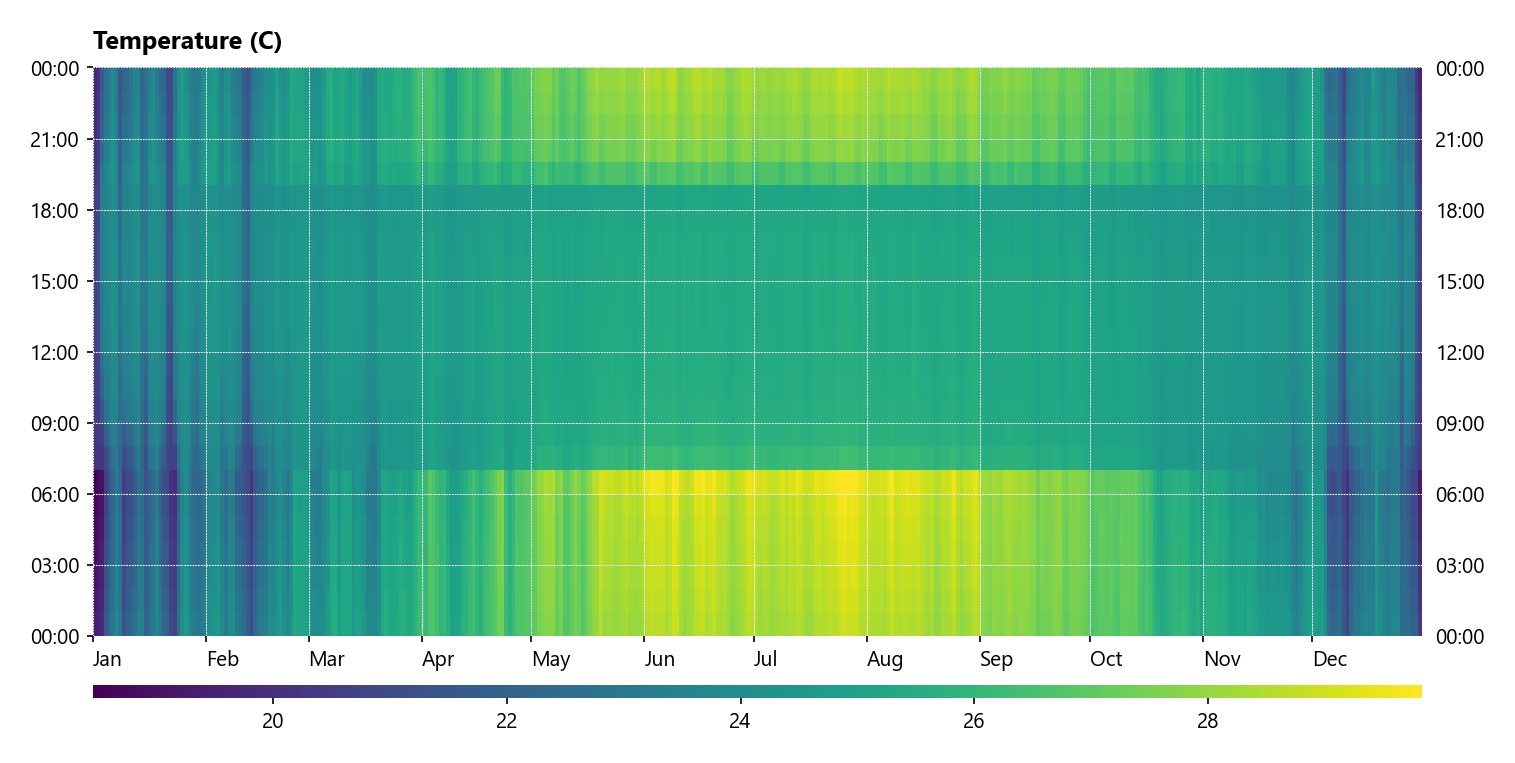

In [ ]:
from ladybugtools_toolkit.plot.timeseries_heatmap import timeseries_heatmap
from ladybugtools_toolkit.ladybug_extension.datacollection import to_series

# For non-normalised results, e.g Temperatures
var_name = 'Zone Operative Temperature'
var_result = sql_obj.data_collections_by_output_name(var_name)
plot = timeseries_heatmap(to_series(var_result[0]))

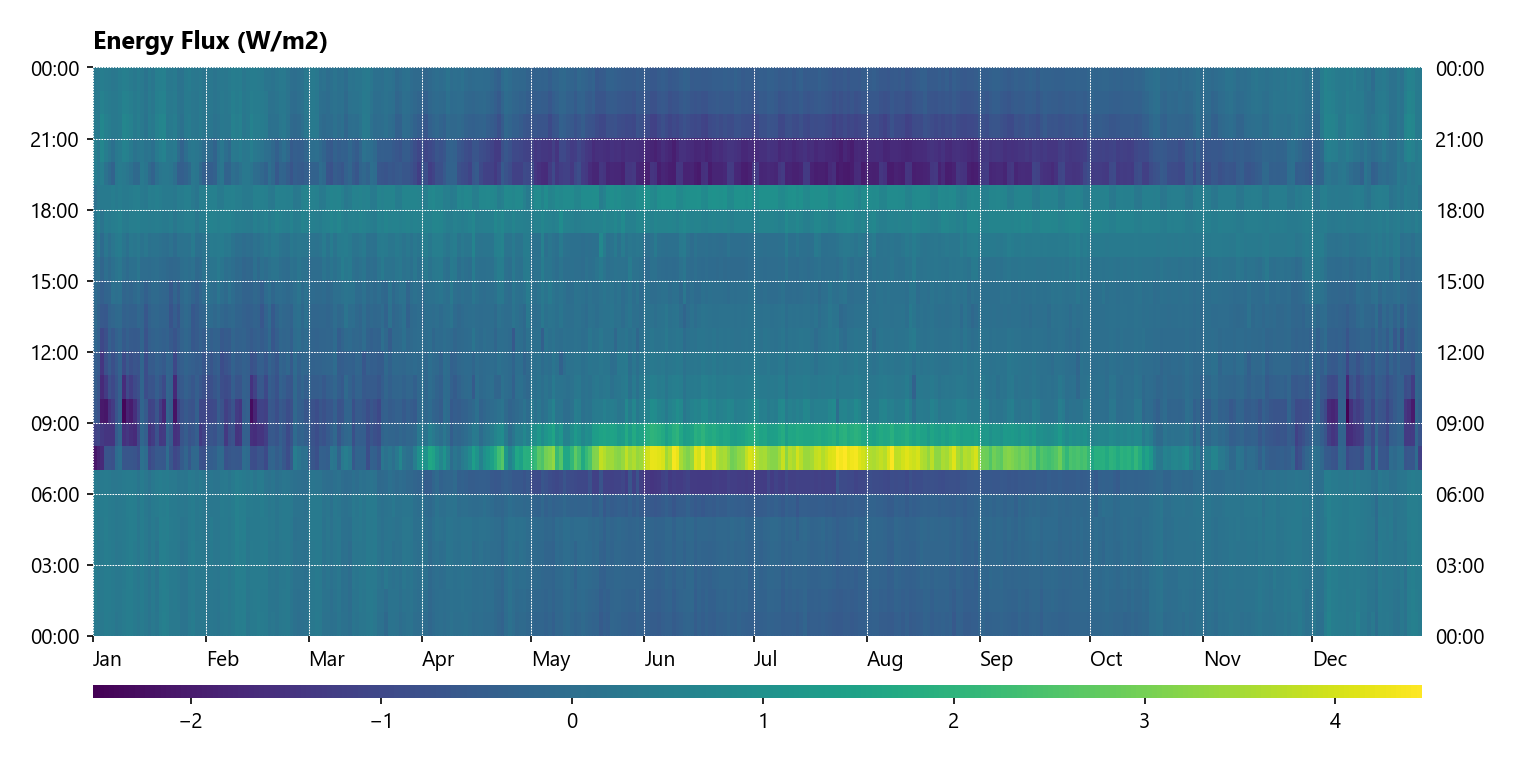

In [ ]:
from ladybugtools_toolkit.plot.timeseries_heatmap import timeseries_heatmap
from ladybugtools_toolkit.ladybug_extension.datacollection import to_series

# For normalised variables, ie W/m2
fa = my_room.floor_area

var_name = 'Surface Inside Face Conduction Heat Transfer Energy'
var_result = sql_obj.data_collections_by_output_name(var_name)

normalised_output = var_result[0]
normalised_output = normalised_output.normalize_by_area(fa, 'm2')
normalised_output_rate = normalised_output.to_time_rate_of_change()
plot = timeseries_heatmap(to_series(normalised_output_rate))